In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import SR1, BFGS
from scipy.optimize import minimize

import cvxpy as cp

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold

plt.rcParams.update({'font.size': 16})

# local modules
import hyperparam

# Hyperparameter Tuning for LaLonde Long

## Load LaLonde data:

In [ ]:
X = pd.read_csv('./data/nsw_psid_X.csv', index_col=0)
T = pd.read_csv('./data/nsw_psid_T.csv', index_col=0)
Y = pd.read_csv('./data/nsw_psid_Y.csv', index_col=0)

In [ ]:
Y = np.array(Y).reshape(-1)
T = np.array(T).reshape(-1)
X = np.array(X)

### separate control and treated groups

In [ ]:
Xp = X[T==0]
Xq = X[T==1]

yp = Y[T==0]

Xpc = Xp - Xp.mean(axis=0)
ypc = yp - yp.mean()

In [ ]:
n = Xpc.shape[0]
d = Xpc.shape[1]

## Ridge outcome model w/ cv

In [ ]:
ridge_params = {'alpha':np.linspace(1e-10, 300, 1000)}
ridge_cv = GridSearchCV(Ridge(max_iter=1200, fit_intercept=False), param_grid=ridge_params,cv=3).fit(Xpc, ypc)

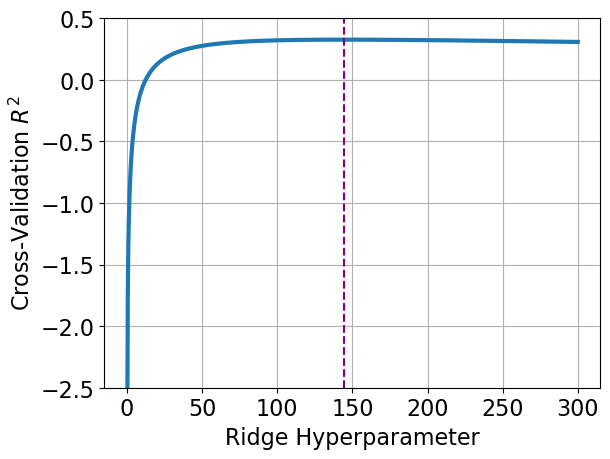

In [ ]:
plt.plot(np.array(ridge_cv.cv_results_['param_alpha']), np.array(ridge_cv.cv_results_['mean_test_score']), linewidth=3)
plt.axvline(ridge_cv.best_estimator_.alpha, color='purple', linestyle='--')
plt.xlabel("Ridge Hyperparameter")
plt.ylabel("Cross-Validation $R^2$")
plt.ylim([-2.5, 0.5])
plt.grid()

In [ ]:
ridge_cv.best_estimator_.alpha / n

0.19868561821801417

In [ ]:
ridge_muhat = ridge_cv.best_estimator_

## Lasso outcome model w/ cv

In [ ]:
lasso_params = {'alpha':np.linspace(100, 1200, 500)}
lasso_cv = GridSearchCV(Lasso(max_iter=1200, fit_intercept=False), param_grid=lasso_params).fit(Xpc, ypc)

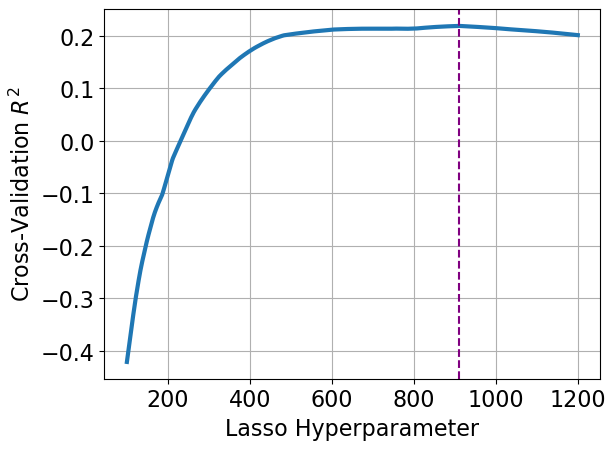

In [ ]:
plt.plot(np.array(lasso_cv.cv_results_['param_alpha']) , np.array(lasso_cv.cv_results_['mean_test_score']), linewidth=3)
plt.axvline(lasso_cv.best_estimator_.alpha, color='purple', linestyle='--')
plt.xlabel("Lasso Hyperparameter")
plt.ylabel("Cross-Validation $R^2$")
plt.grid()

In [ ]:
lasso_muhat = lasso_cv.best_estimator_

# Fitting the Weights:

In [ ]:
Xqc = (Xq - Xp.mean(axis=0))
Xqb = Xq.mean(axis=0)
Xqcb = Xqc.mean(axis=0)

In [ ]:
# Note that there is randomness in the splits.
# I fix the random seed to make a clear figure.
# But we could also average over many repeats of the splits.
deltas = np.linspace(0,20, 1000)
imbals = hyperparam.cross_val_bal_solver(Xqcb, Xp, repeats=1, seed=6401433, plot=True, plot_deltas=deltas )

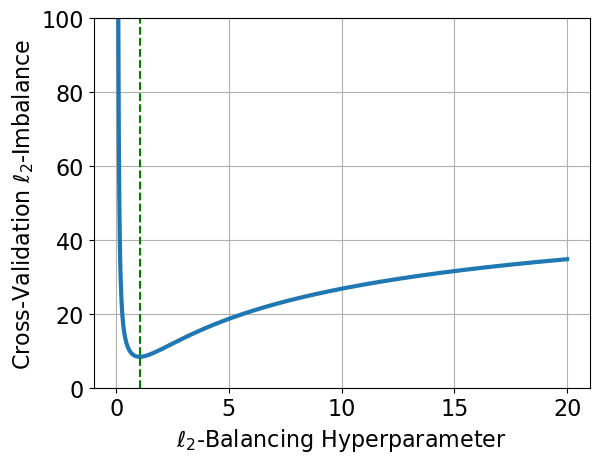

In [ ]:
plt.plot(deltas, imbals, linewidth=3)

ridge_bal_cv = deltas[np.argmin(imbals)]

plt.axvline(ridge_bal_cv, color='green', linestyle='--')
plt.xlabel("$\ell_2$-Balancing Hyperparameter")
plt.ylabel("Cross-Validation $\ell_2$-Imbalance")
plt.ylim([0,100])
plt.grid()

In [ ]:
deltas = np.linspace(0,1, 1000)
auto_losses = hyperparam.cross_val_autodml_solver(Xqcb, Xp, repeats=1, plot=True, plot_deltas=deltas, seed=1)

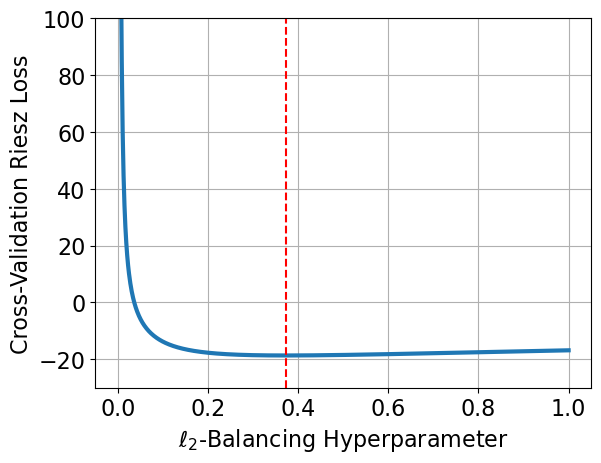

In [ ]:
ridge_auto_cv = deltas[np.argmin(auto_losses)]

plt.plot(deltas, auto_losses, linewidth=3)
plt.axvline(ridge_auto_cv, color='red', linestyle='--')
plt.xlabel("$\ell_2$-Balancing Hyperparameter")
plt.ylabel("Cross-Validation Riesz Loss")
plt.ylim([-30,100])
plt.grid()

# Check Linf balance

In [42]:
def MDL(delta,Xpc,Xq):

    N=Xpc.shape[0]
    M=Xpc.shape[1]

    rho = cp.Variable(M)

    w = Xpc@rho

    prob = cp.Problem(cp.Minimize( cp.sum_squares(w)/N - 2*rho@Xq + delta*cp.norm(rho,1) ))
    
    optimal_value = prob.solve()

    return(rho.value)

In [43]:
deltas = np.linspace(0,5,300)

ks = 5
kf = KFold(n_splits=ks, shuffle=True, random_state=100) 
all_losses = []
all_thetas = []
all_imbals = []
for i, (train_index, test_index) in enumerate(kf.split(Xp)):
    trainMean = Xp[train_index, :].mean(axis=0)
    Xtrain = Xp[train_index, :] - trainMean
    Xtest = Xp[test_index, :] - trainMean

    nt = Xtrain.shape[0]
    
    thetas = []
    losses = []
    imbals = []
    for delta in deltas:
        theta = MDL(delta, Xtrain, Xqcb)

        theta[np.abs(theta) < 1e-10] = 0

        loss = hyperparam.autodml_loss(theta, Xtest, Xqcb)
        imbal = hyperparam.calc_imbal(theta, Xtest, Xqcb)
        thetas.append( theta )
        losses.append(loss)
        imbals.append(imbal)

    all_losses.append(losses)
    all_thetas.append(thetas)
    all_imbals.append(imbals)

cv_del = deltas[np.argmin(np.array(all_losses).mean(axis=0))]

c:\Users\david\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


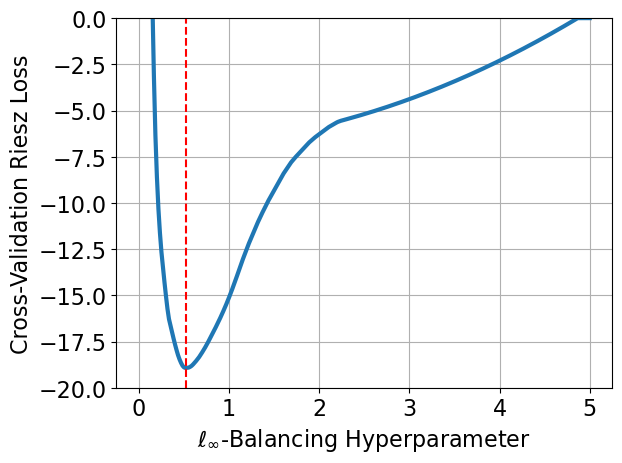

In [44]:
avg_losses = np.array(all_losses).mean(axis=0)

plt.plot(deltas, avg_losses, linewidth=3)

lasso_auto_cv = deltas[np.argmin(avg_losses)]

plt.axvline(lasso_auto_cv, color='red', linestyle='--')
plt.xlabel("$\ell_\infty$-Balancing Hyperparameter")
plt.ylabel("Cross-Validation Riesz Loss")
plt.ylim([-20,0])
plt.grid()

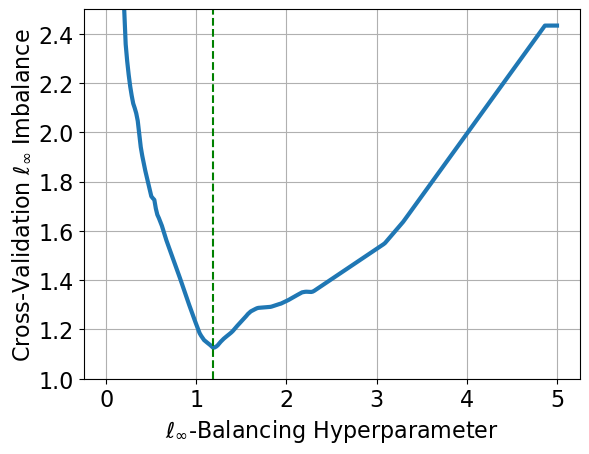

In [45]:
avg_imbals = np.array(all_imbals).mean(axis=0)

plt.plot(deltas, avg_imbals, linewidth=3)

lasso_bal_cv = deltas[np.argmin(avg_imbals)]

plt.axvline(lasso_bal_cv, color='green', linestyle='--')
plt.xlabel("$\ell_\infty$-Balancing Hyperparameter")
plt.ylabel("Cross-Validation $\ell_\infty$ Imbalance")
plt.ylim([1,2.5])

plt.grid()

### plot sweep of final augmented point estimates

In [22]:
betahat = ridge_muhat.coef_
deltas = np.linspace(0, 4, 500)
aug_points = []
for delta in deltas:
    rhohat = np.linalg.pinv(Xpc.T@Xpc/n + delta*np.eye(Xpc.shape[1])) @ Xqcb
    what = Xpc@rhohat/n

    aug = Xqcb@betahat + what@(ypc - Xpc@betahat)
    aug_points.append(aug)

In [23]:
# rhohat = np.linalg.inv(Xpc.T@Xpc/n + autodml_delta*np.eye(Xpc.shape[1])) @ Xqcb
# what = Xpc@rhohat/n

# aug = Xqcb@betahat + what@(ypc - Xpc@betahat)
# print(Y[T==1].mean() - (yp.mean()+aug))

In [24]:
betaols = np.linalg.pinv(Xpc.T@Xpc)@Xpc.T@ypc

Text(0, 0.5, 'Augmented Point Estimate')

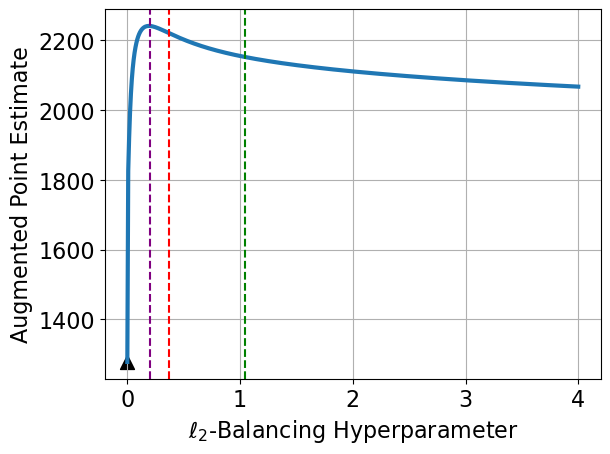

In [25]:
plt.plot(deltas,Y[T==1].mean() - (yp.mean()+np.array(aug_points)), linewidth=3)
plt.scatter(0,Y[T==1].mean() - (yp.mean()+Xqcb@betaols),color='black', marker='^', s=100)
#plt.axvline(mean_opt_delta2, color='blue', linestyle='--')
plt.axvline(ridge_muhat.alpha/n, color='purple', linestyle='--')
plt.axvline(ridge_bal_cv, color='green', linestyle='--')
plt.axvline(ridge_auto_cv, color='red', linestyle='--')

plt.grid()
plt.xlabel("$\ell_2$-Balancing Hyperparameter")
plt.ylabel("Augmented Point Estimate")

In [ ]:
betahat = lasso_muhat.coef_
deltas = np.linspace(0,1.5,300)
aug_points = []
for delta in deltas:

    if delta == 0:
        aug_points.append(Xqcb@betaols)
        continue

    theta = MDL(delta, Xpc, Xqcb)

    theta[np.abs(theta) < 1e-10] = 0

    what = Xpc@theta/n

    aug = Xqcb@betahat + what@(ypc - Xpc@betahat)
    aug_points.append(aug)

In [27]:
lasso_bal_cv

1.1872909698996654

Text(0, 0.5, 'Augmented Point Estimate')

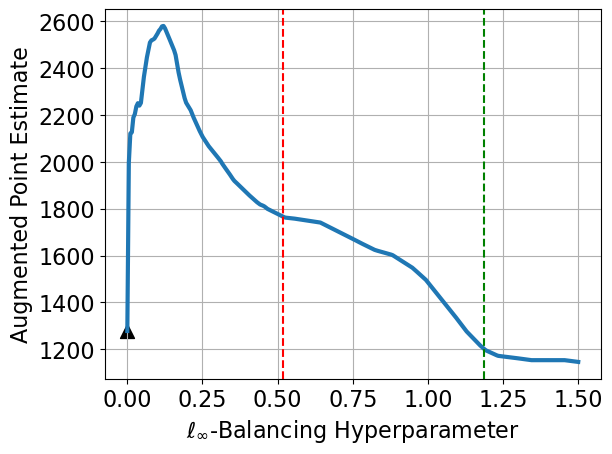

In [28]:
plt.plot(deltas,Y[T==1].mean() - (yp.mean()+np.array(aug_points)), linewidth=3)
plt.scatter(0,Y[T==1].mean() - (yp.mean()+Xqcb@betaols),color='black', marker='^', s=100)

plt.axvline(lasso_bal_cv, color='green', linestyle='--')
plt.axvline(lasso_auto_cv, color='red', linestyle='--')

plt.grid()
plt.xlabel("$\ell_\infty$-Balancing Hyperparameter")
plt.ylabel("Augmented Point Estimate")